In [1]:
import numpy as np
import matplotlib.pyplot as plt

# setting up constants

In [2]:
N = 10
l = 10
rhow = 10**3
rhois = 913
n = 3
R = 8.31446261815324  # J/mol/K
g = 9.82
sec_per_year = 365.25 * 24 * 60 * 60
#tunable parameters
a = 2
b = 3


# Defining individual functions

In [3]:

def getEffectiveDeviatoricStress(stress):
    """
    Computes the effective deviatoric stress for the given stress tensor.

    :param stress: Stress tensor, assumed to be symmetric.
    :type stress: numpy.ndarray
    :return: The calculated effective deviatoric stress.
    :rtype: float
    """
    return 1/2 * np.tensordot(stress,stress)

def getDeviatoric(tensor):
    """
    Calculate the deviatoric part of a tensor.

    :param tensor: Input tensor to compute the deviatoric part. Should be of size 3x3
    :type tensor: numpy.ndarray
    :return: The deviatoric part of the input tensor.
    :rtype: numpy.ndarray
    """
    return tensor - (1/3 * np.trace(tensor)*np.eye(3))

def getPressure(stress):
    '''
    Calculates the hydrostatic pressure tensor
    :param stress: 3x3 symmetric numpy array
    :return: np.ones like array with p along axis
    '''
    return -1/3 *np.trace(stress)*np.eye(3)


def getEffectiveStress(stress):
    """
    Computes the effective stress based on input stress tensor.

    :param stress: numpy.ndarray
        The stress tensor input for which effective stress is computed.
    :return: float
        The computed effective stress.
    """
    effectiveDeviatoricStress = getEffectiveDeviatoricStress(stress)
    pressure = getPressure(stress)[0,0]
    effectiveStress = np.sqrt(a*effectiveDeviatoricStress**2 +1/3*b*pressure**2)
    return effectiveStress

def getStrainRate(stress, a, b, A, n=3):
    """
    Calculates the strain rate based on the provided stress tensor using constitutive relationships.

    This function computes the strain rate by first calculating the effective stress,
    deviatoric stress, and pressure from the input stress tensor.

    :param stress: The stress tensor used to compute strain rate. 3x3 numpy array
    :return: The computed strain rate. float
    """
    deviatoricStress = getDeviatoric(stress)
    effectiveDeviatoricStress = getEffectiveStress(deviatoricStress)
    pressure = getPressure(stress)
    se2 = a* effectiveDeviatoricStress + (b* pressure**2)/3
    phi = A *se2**((n - 1)/2)
    strainRates = phi*(a*deviatoricStress - 2*b*pressure*np.eye(3)/9)
    return strainRates

# def Overburden(rho, dz):
#     """
#     :param rho: A list representing density values at different depth intervals.
#     :type rho: list[float]
#     :param dz: A list representing thickness (depth intervals) corresponding to the density values.
#     :type dz: list[float]
#     :return: The total overburden (vertical stress).
#     :rtype: float
#     """
#     burden = 0
#     for i in range(len(rho)):
#         burden += rho[i]*dz[i]
#     return g*burden

def r_fun(a, b):
    return 2 / (3 * a) + 3 / (2 * b)

def closed_form_cubic_root(k3, k2, k1, k0):
    # https://medium.com/@mephisto_Dev/solving-cubic-equation-using-cardanos-method-with-python-9465f0b92277
    p = (3 * k3 * k1 - k2**2) / (3 * k3**2)
    q = (2 * k2**3 - 9 * k3 * k2 * k1 + 27 * k3**2 * k0) / (27 * k3**3)
    delta = q**2 / 4 + p**3 / 27
    u = np.cbrt(-q / 2 + np.sqrt(delta))
    v = np.cbrt(-q / 2 - np.sqrt(delta))
    return u + v - k2 / (3 * k3)

def gagliardini_ezz(sigma_zz, a, b, A, e1=0, e2=0):
    # assuming e1=0 and e2=0
    # assuming n=3 (and no additional linear term in the rheology!)
    if b == 0:
        return -e1 - e2
    r = r_fun(a, b)
    p = (e1 + e2) / (3 * a) - 3 * (e1 + e2) / (2 * b)
    Asig3 = A * sigma_zz**3
    k0 = (
        Asig3 * ((e1**2 + e2**2 - e1 * e2) / (3 * a) + 3 * (e1 + e2) ** 2 / (4 * b))
        + p**3
    )
    k1 = -p * Asig3 - 3 * p**2 * r
    k2 = 0.5 * r * Asig3 + 3 * p * r**2
    k3 = -(r**3)
    return closed_form_cubic_root(k3, k2, k1, k0)

def a_fun(rho):
    # zwinger 2007
    r = rho / rhois
    a1 = np.exp(13.22240 - 15.78652 * r)
    a2 = (1 + (2 / 3) * (1 - r)) * (r ** (-1.5))  # assuming n=3
    return np.where(r < 0.81, a1, a2) # selects a1 if r< 0.81 else it returns a2


def b_fun(rho):  # note the factor 3 difference between zwinger and JL
    r = rho / rhois
    b1 = np.exp(15.09371 - 20.46489 * r)
    b2 = 0.75 * ( ((1 - r) ** (1 / 3)) / (3 * (1 - (1 - r) ** (1 / 3) ) ) ) ** (
        1.5
    )  # assuming n=3
    return np.where(r < 0.81, b1, b2) / 3


# testing fuctions

In [4]:
testArray = np.array(([1,2,3],
                     [2,4,5],
                     [3,5,1]))

In [5]:
effectiveStress = getEffectiveStress(testArray)
deviatoricStress = getDeviatoric(testArray)
pressure = getPressure(testArray)
strainRates = effectiveStress**(n-1)*(a*deviatoricStress - 2/3*b*pressure)

In [6]:
print('effecttiveStress',effectiveStress,'?', 'deviatoricStress', deviatoricStress, '?', 'pressure',pressure, '?', 'strain rate', strainRates)

effecttiveStress 66.4981202741852 ? deviatoricStress [[-1.  2.  3.]
 [ 2.  2.  5.]
 [ 3.  5. -1.]] ? pressure [[-2. -0. -0.]
 [-0. -2. -0.]
 [-0. -0. -2.]] ? strain rate [[ 8844. 17688. 26532.]
 [17688. 35376. 44220.]
 [26532. 44220.  8844.]]


**Introducing densification model**
Vi har en array med densiteter -> horizontale stress fra satelitter eller målebokse ->For hvert lag skal der så ske følgende.

Den nuværende 'burden' skal udregnes $\sigma_{zz}$
ud fra densiteten skal a og b udregnes.

de honrisontale stress komponenter skal diagonaliseres og sammen med de andre ting fodres til gaglardini_ezz.
Vha massebevarelse $(\frac{D\rho}{Dt}) = (\epsilon_{xx(1)}+\epsilon_{yy(2)} + \epsilon_{z})$




$$
\rho_{new} = \rho_{old} + (\frac{D\rho}{Dt}) \cdot dt
$$
Vil gerne implementere $(\frac{D\rho}{Dt})$ sådan at den kan udregnes for hver celle ved et funktionskald


In [7]:
def r_fun(a, b):
    return 2 / (3 * a) + 3 / (2 * b)

def closed_form_cubic_root(k3, k2, k1, k0):
    # https://medium.com/@mephisto_Dev/solving-cubic-equation-using-cardanos-method-with-python-9465f0b92277
    p = (3 * k3 * k1 - k2**2) / (3 * k3**2)
    q = (2 * k2**3 - 9 * k3 * k2 * k1 + 27 * k3**2 * k0) / (27 * k3**3)
    delta = q**2 / 4 + p**3 / 27
    if delta < 0 and delta > -1*1e-10:
        delta = 0
    assert delta>=0, 'no complex root allowed'
    u = np.cbrt(-q / 2 + np.emath.sqrt(delta))
    v = np.cbrt(-q / 2 - np.emath.sqrt(delta))
    # print(f"p {p}, q {q}, u {u}, v {v}, delta {delta}")
    return u + v - k2 / (3 * k3)

def gagliardini_ezz(sigma_zz, a, b, A, e1=0, e2=0):
    # assuming e1=0 and e2=0
    # assuming n=3 (and no additional linear term in the rheology!)
    if b == 0:
        return -e1 - e2
    r = r_fun(a, b)
    p = (e1 + e2) / (3 * a) - 3 * (e1 + e2) / (2 * b)
    Asig3 = A * sigma_zz**3
    k0 = (
        Asig3 * ((e1**2 + e2**2 - e1 * e2) / (3 * a) + 3 * (e1 + e2) ** 2 / (4 * b))
        + p**3
    )
    k1 = -p * Asig3 - 3 * p**2 * r
    k2 = 0.5 * r * Asig3 + 3 * p * r**2
    k3 = -(r**3)
    # print(f'k3- {k3}, k2-{k2}, k1-{k1}, k0-{k0}')
    return closed_form_cubic_root(k3, k2, k1, k0)

def Burden(zGrid):
    F = [0]
    N = len(zGrid)
    for i in range(N):
        Parcel = zGrid[i]
        dF = g*Parcel[0]*Parcel[1]
        F.append(dF)
    return np.cumsum(F)

def A_fun(T):
    A1 = 3.985e-13 * np.exp(-60e3 / (R * T))
    A2 = 1.916e3 * np.exp(-139e3 / (R * T))
    return np.maximum(A1, A2)
def Diagonalize(M):
    L = np.linalg.eig(M)
    return np.diag(L[0])
# Volume = 1
# Height = 1
# WidthX = 1
# bdot = 300 / sec_per_year #kg/m2/s
# steps = 100
# # rho_fern = 350 #kg/m3
# dt = 24*60*60
# z = []
# ez_array = []
# A = A_fun(273-30)
# YearlySteps = int(sec_per_year/dt)
# e1 = 0
# e2 = 0
# for i in range(steps): #all snow accumulates in the same grid cell for one year, so steps determines the total amout of rows created
#     CellDensity = 0
#     parcel = np.array([0, Volume, Height, WidthX]) #creating a new cell
#     z.append(parcel)#adding the parcel to the zarray
#     for ii in range(0, YearlySteps-1):#running through the year
#         CellDensity += bdot*dt
#         z[i][0] = CellDensity
#         OverBurden = Burden(z)
#         # print(z[i][0]) printing the cell densities with time / debgugging
#         for iii in range (0, len(z) - 1): # updating the above cells
#             parcel = z[iii]
#             rho = parcel[0]
#             height = parcel[2]
#             SigmaZZ = -OverBurden[len(z)-iii]
#             # print(f'SigmaZZ{SigmaZZ}, zlayer {iii}')
#             a = a_fun(rho)
#             b = b_fun(rho)
#             # print(r_fun(a,b))
#             ezz = gagliardini_ezz(SigmaZZ, a, b, A)
#             dRhoDt = -(e1+e2+ezz)*rho
#             new_rho = dRhoDt*dt + rho
#             Uz = ezz*dt*height
#             strain = ezz * dt
#             new_height = height*(1 + strain)
#             new_parcel = np.array([new_rho, Volume, new_height, WidthX ])
#             z[iii] = new_parcel
#             # print(f'nH{New_height}, height{height}')
#             # print(f'new_H {new_height:.4f}, strain {strain:.6f}, iii{iii}')
#             # print(z[iii][2])
#             # print(f"    Layer {iii}: ezz = {ezz}, dRhoDt = {dRhoDt}, rho_after = {z[iii][0]}")
#
#     #     print('..')
#     # print('---')



In [8]:

def SimulateFern(steps,HorizontalStress):
    Volume = 1
    Height = 1
    WidthX = 1
    bdot = 300 / sec_per_year #kg/m2/s
    dt = 24*60*60
    z = []
    ez_array = []
    A = A_fun(273-30)
    YearlySteps = int(sec_per_year/dt)
    e1 = 0
    e2 = 0
    for i in range(steps): #all snow accumulates in the same grid cell for one year, so steps determines the total amout of rows created
        e1, e2 = HorizontalStress[i,:]
        CellDensity = 0
        parcel = np.array([0, Volume, Height, WidthX]) #creating a new cell
        z.append(parcel)#adding the parcel to the zarray
        for ii in range(0, YearlySteps-1):#running through the year
            CellDensity += bdot*dt
            z[i][0] = CellDensity
            OverBurden = Burden(z)
            # print(z[i][0]) printing the cell densities with time / debgugging
            for iii in range (0, len(z) - 1): # updating the above cells
                parcel = z[iii]
                rho = parcel[0]
                height = parcel[2]
                SigmaZZ = -OverBurden[len(z)-iii]
                # print(f'SigmaZZ{SigmaZZ}, zlayer {iii}')
                a = a_fun(rho)
                b = b_fun(rho)
                # print(r_fun(a,b))
                ezz = gagliardini_ezz(SigmaZZ, a, b, A, e1 = e1, e2=e2)
                dRhoDt = -(e1+e2+ezz)*rho
                new_rho = dRhoDt*dt + rho
                strain = ezz * dt
                new_height = height*(1 + strain)
                new_parcel = np.array([new_rho, Volume, new_height, WidthX ])
                z[iii] = new_parcel
    return z

steps = 170
HSigma = np.zeros([steps,2])
I1 = np.array([[-5*1e-11,2*1e-11] for i in range(steps)])
# I2 = np.array([[-1*1e-11,-1*1e-11] for i in range(steps)])
zH1 = SimulateFern(steps, I1)
# zH2 = SimulateFern(steps, I2)
z = SimulateFern(steps, HSigma)

KeyboardInterrupt: 

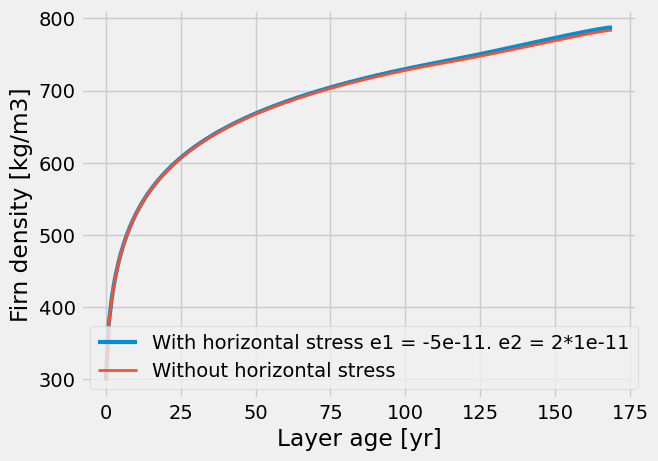

In [60]:
Years = np.arange(0, steps)
plt.style.use('fivethirtyeight')
plt.plot(Years, np.asarray(zH1)[::-1, 0], linewidth=3, label='With horizontal stress e1 = -5e-11. e2 = 2*1e-11')
# plt.plot(Years, np.asarray(zH2)[::-1, 0], linewidth=1, label='With horizontal stress -1e-11 ' )
plt.plot(Years, np.asarray(z)[::-1, 0], linewidth=2, label='Without horizontal stress')

plt.xlabel('Layer age [yr]')
plt.ylabel('Firn density [kg/m3]')
plt.legend()


In [42]:
A = np.array([[5,5], [1,2]])
B = np.diag(np.linalg.eig(A)[0])

Diagonalize(A)

array([[6.1925824, 0.       ],
       [0.       , 0.8074176]])

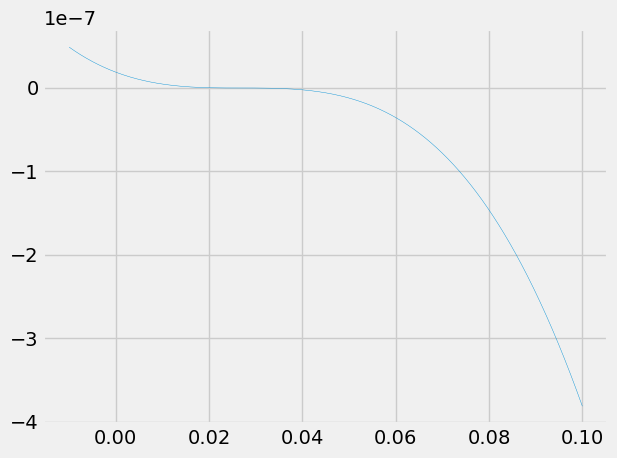

In [65]:
def Modified_gagliardini_ezz(sigma_zz, a, b, A, e1=0, e2=0):
    # assuming e1=0 and e2=0
    # assuming n=3 (and no additional linear term in the rheology!)
    if b == 0:
        return -e1 - e2
    r = r_fun(a, b)
    p = (e1 + e2) / (3 * a) - 3 * (e1 + e2) / (2 * b)
    Asig3 = A * sigma_zz**3
    k0 = (
        Asig3 * ((e1**2 + e2**2 - e1 * e2) / (3 * a) + 3 * (e1 + e2) ** 2 / (4 * b))
        + p**3
    )
    k1 = -p * Asig3 - 3 * p**2 * r
    k2 = 0.5 * r * Asig3 + 3 * p * r**2
    k3 = -(r**3)
    # print(f'k3- {k3}, k2-{k2}, k1-{k1}, k0-{k0}')
    return k3,k2,k1,k0
ks = Modified_gagliardini_ezz(sigma_zz=-91700, a = a_fun(500), b = b_fun(500), e1=-5e-2, e2=2e-2, A = A_fun(273-30))
x = np.linspace(-0.01, 0.1, 1000)

def cubic_eq(x,a,b,c,d):

    return a*x**3 +b*x**2 + c*x + d
y = cubic_eq(x,ks[0], ks[1], ks[2], ks[3])
fig, ax = plt.subplots()
ax.plot(x, y, linewidth = 0.3)
plt.tight_layout()
